# Evaluate forecasts

In this notebook, we will compute all the scores for the baseline models and create the figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '/data/weather-benchmark/5.625deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

## Load data

First let's load all the prediction files from the previous notebooks.

In [5]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [6]:
persistence = xr.open_dataset(f'{PREDDIR}persistence.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology.nc')

In [7]:
lr_3d = xr.open_dataset(f'{PREDDIR}fc_lr_3d.nc')
lr_5d = xr.open_dataset(f'{PREDDIR}fc_lr_5d.nc')
lr_6h_iter = xr.open_dataset(f'{PREDDIR}fc_lr_6h_iter.nc')

In [8]:
cnn_3d = xr.open_dataset(f'{PREDDIR}fccnn_3d.nc')
cnn_5d = xr.open_dataset(f'{PREDDIR}fccnn_5d.nc')
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}fccnn_6h_iter.nc')

In [9]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_5.625deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

## TIGGE and IFT T21 data

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

You can skip this step if you alread managed to load the data above. This takes a while.

In [43]:
# Convert from geopotential height to geopotential
tigge_raw_z = xr.open_mfdataset('/media/rasp/Elements/weather-benchmark/tigge/5.625deg/z*.nc').squeeze()
tigge_raw_t = xr.open_mfdataset('/media/rasp/Elements/weather-benchmark/tigge/5.625deg/t*.nc').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
htt

In [44]:
tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [45]:
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 30660)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>

In [46]:
# Convert from geopotential height to geopotential
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 30660)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-01-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>

In [48]:
tigge_raw = tigge_raw.drop('gh')

In [8]:
t42_raw = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_5.625.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [54]:
t42_raw_new = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_5.625_new.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [68]:
t42_hr = xr.open_dataset('/media/rasp/Elements/weather-benchmark/IFS_T41/output_42_pl_2.8125.nc')

In [72]:
my5 = xr.open_dataset('/media/rasp/Elements/weather-benchmark/IFS_T41/my5.625.nc')

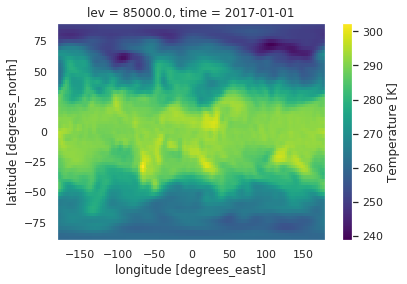

In [70]:
t42_hr.t.isel(time=0).sel(lev=8.5e4).plot()

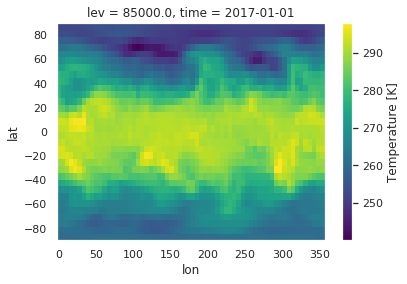

In [73]:
my5.t.isel(time=0).sel(lev=8.5e4).plot()

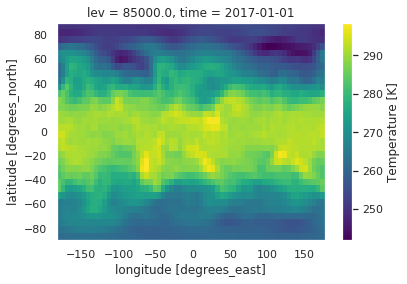

In [74]:
t42_orig.t.isel(time=0).sel(lev=8.5e4).plot()

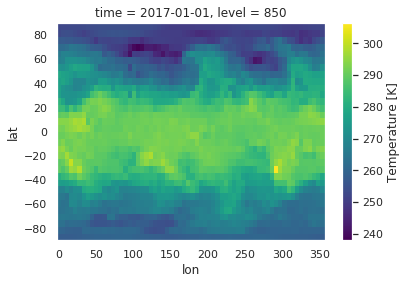

In [71]:
valid_data.t.isel(time=0).plot()

In [9]:
t42_orig = t42_raw.copy()

In [10]:
t42_raw = t42_orig.copy()

In [11]:
t42_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 4, lon: 64, time: 522)
Coordinates:
  * lon      (lon) float64 -180.0 -174.4 -168.8 -163.1 ... 163.1 168.8 174.4
  * lat      (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
  * lev      (lev) float64 1e+05 8.5e+04 5e+04 2e+04
  * time     (time) datetime64[ns] 2017-01-01 2017-01-01T06:00:00 ... 2017-05-07
Data variables:
    z        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    t        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    r        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    u        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
    v        (time, lev, lat, lon) float32 dask.array<chunksize=(522, 4, 32, 64), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    h

In [12]:
t42_raw['lat'] = -tigge_raw_z.lat
t42_raw = t42_raw.roll(lon=32)
t42_raw['lon'] = tigge_raw_z.lon

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [55]:
t42_raw_new['lat'] = -tigge_raw_z.lat
t42_raw_new = t42_raw_new.roll(lon=32)
t42_raw_new['lon'] = tigge_raw_z.lon

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [13]:
t42_raw.lat

<xarray.DataArray 'lat' (lat: 32)>
array([ 87.1875,  81.5625,  75.9375,  70.3125,  64.6875,  59.0625,  53.4375,
        47.8125,  42.1875,  36.5625,  30.9375,  25.3125,  19.6875,  14.0625,
         8.4375,   2.8125,  -2.8125,  -8.4375, -14.0625, -19.6875, -25.3125,
       -30.9375, -36.5625, -42.1875, -47.8125, -53.4375, -59.0625, -64.6875,
       -70.3125, -75.9375, -81.5625, -87.1875])
Coordinates:
  * lat      (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19

In [49]:
def convert_time(ds, nlead_time):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, 6*nlead_time, 6), dims=['lead_time'], coords={'lead_time': np.arange(0, 6*nlead_time, 6)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [50]:
tigge = convert_time(tigge_raw, 21)

In [51]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 1460)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lat, lon) float32 257.98013 ... 252.24873
    z          (time, lead_time, lat, lon) float32 50928.676 ... 49982.945

In [46]:
tigge_t

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lev: 2, lon: 64, time: 608)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lev        (lev) float64 5e+04 8.5e+04
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    t          (time, lead_time, lev, lat, lon) float32 247.54436 ... 260.41785

In [78]:
tigge = xr.merge([tigge_z.drop('lev'), tigge_t.sel(lev=8.5e4).squeeze().drop('lev')])

In [79]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 608)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 5205.32 5209.601 ... nan nan
    z          (time, lead_time, lat, lon) float32 51048.574 51090.56 ... nan
    t          (time, lead_time, lat, lon) float32 nan nan ... 260.41785

In [17]:
t42 = convert_time(xr.Dataset({'z': t42_raw.z.sel(lev=5e4), 't': t42_raw.t.sel(lev=8.5e4)}, compat='override'), 29)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The `compat` argument to Dataset is deprecated and will be removed in 0.14.Instead, use `merge` to control how variables are combined
  """Entry point for launching an IPython kernel.


In [56]:
t42_new = convert_time(xr.Dataset({'z': t42_raw_new.z.sel(lev=5e4), 't': t42_raw_new.t.sel(lev=8.5e4)}, compat='override'), 29)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The `compat` argument to Dataset is deprecated and will be removed in 0.14.Instead, use `merge` to control how variables are combined
  """Entry point for launching an IPython kernel.


In [52]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc2')

In [54]:
PREDDIR

'/data/weather-benchmark/predictions/'

In [28]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lon: 64, time: 608)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    lev        float64 5e+04
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-10-31T12:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 5193.094 ... 5110.644
    t          (time, lead_time, lat, lon) float32 241.34908 ... 234.8365
    z          (time, lead_time, lat, lon) float32 50928.676 ... 50120.086

In [75]:
tigge

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 21, lev: 2, lon: 64, time: 608)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-10-31T12:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lev        (lev) float64 5e+04 8.5e+04
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 84 90 96 102 108 114 120
Data variables:
    gh         (time, lead_time, lat, lon) float32 ...
    z          (time, lead_time, lat, lon) float32 ...
    t          (time, lead_time, lev, lat, lon) float32 ...

In [ ]:
t21.to_netcdf(f'{PREDDIR}/t21_5.625deg.nc')

In [20]:
t42.to_netcdf(f'{PREDDIR}/t42_5.625deg.nc')

## T21 Issue

Now we need to compute the RMSE for each of the forecasts

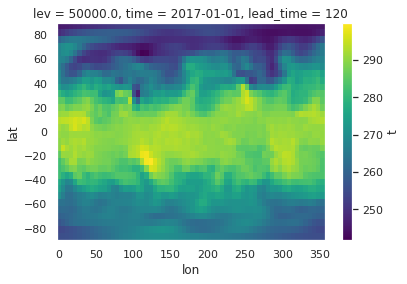

In [42]:
t42.t.isel(time=0).sel(lead_time=5*24).plot()

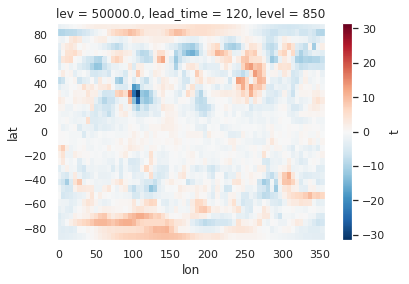

In [46]:
(t42.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24)).plot()

In [49]:
np.sqrt(((t42.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24))**2).mean()).values

array(4.1005573, dtype=float32)

In [53]:
(np.abs((t42.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24)))).mean().values

array(2.9255536, dtype=float32)

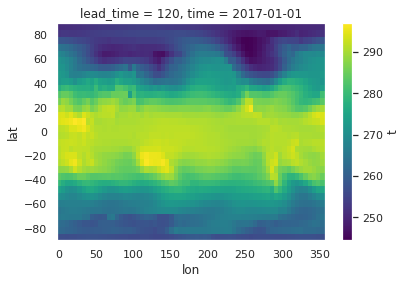

In [44]:
lr_6h_iter.t.isel(time=0).sel(lead_time=5*24).plot()

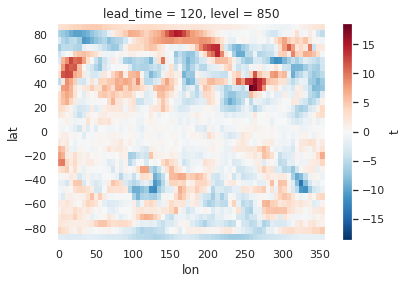

In [47]:
(lr_6h_iter.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24)).plot()

In [50]:
np.sqrt(((lr_6h_iter.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24))**2).mean()).values

array(3.882139, dtype=float32)

In [52]:
(np.abs((lr_6h_iter.t.isel(time=0).sel(lead_time=5*24) - valid_data.t.isel(time=5*24)))).mean().values

array(2.8618069, dtype=float32)

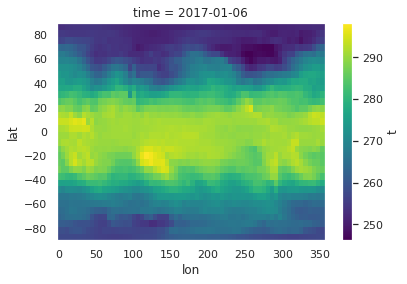

In [45]:
lr_5d.t.isel(time=0).plot()

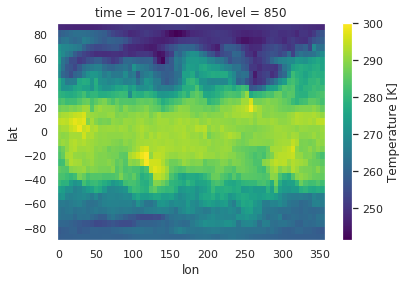

In [43]:
valid_data.t.isel(time=5*24).plot()

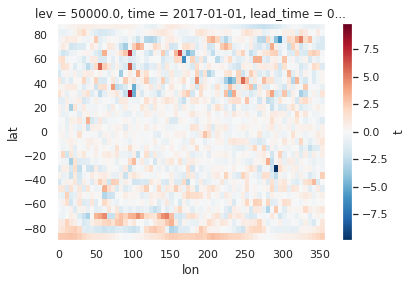

In [37]:
(t42.t.isel(time=0, lead_time=0) - valid_data.t.isel(time=0)).plot()

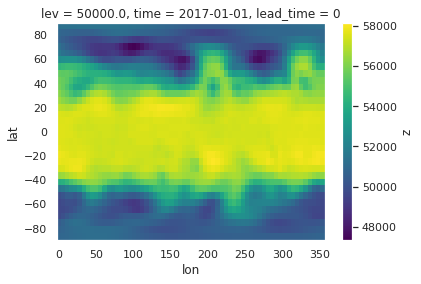

In [38]:
t42.z.isel(time=0, lead_time=0).plot()

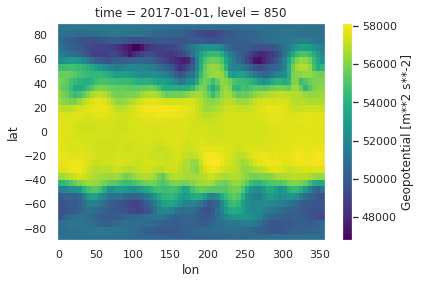

In [39]:
valid_data.z.isel(time=0).plot()

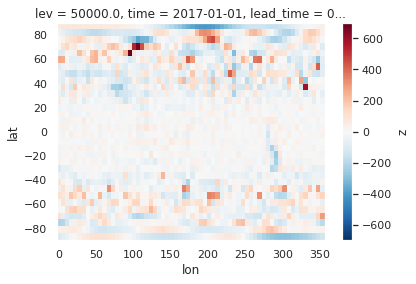

In [40]:
(t42.z.isel(time=0, lead_time=0) - valid_data.z.isel(time=0)).plot()

## Compute RMSE

In [25]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [57]:
t42_rmse_new = evaluate_iterative_forecast(t42_new, valid_data).load()

In [58]:
t42_rmse

<xarray.Dataset>
Dimensions:    (lead_time: 29)
Coordinates:
    lev        float64 5e+04
    level      int32 850
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 138 144 150 156 162 168
Data variables:
    z_rmse     (lead_time) float64 81.09 94.82 124.7 153.3 ... 872.4 893.2 915.8
    t_rmse     (lead_time) float64 1.216 1.33 1.583 1.819 ... 4.358 4.441 4.527

In [59]:
t42_rmse_new

<xarray.Dataset>
Dimensions:    (lead_time: 29)
Coordinates:
    lev        float64 5e+04
    level      int32 850
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 138 144 150 156 162 168
Data variables:
    z_rmse     (lead_time) float64 48.8 73.73 111.7 145.5 ... 880.7 901.4 923.9
    t_rmse     (lead_time) float64 1.037 1.227 1.558 1.834 ... 4.462 4.543 4.628

In [26]:
rmse_persistence = evaluate_iterative_forecast(persistence, valid_data).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

In [27]:
rmse_lr_6h_iter =evaluate_iterative_forecast(lr_6h_iter, valid_data).load()
rmse_lr_3d = compute_weighted_rmse(lr_3d, valid_data).load()
rmse_lr_5d = compute_weighted_rmse(lr_5d, valid_data).load()

In [28]:
rmse_cnn_6h_iter = evaluate_iterative_forecast(cnn_6h_iter, valid_data).load()
rmse_cnn_3d = compute_weighted_rmse(cnn_3d, valid_data).load()
rmse_cnn_5d = compute_weighted_rmse(cnn_5d, valid_data).load()

In [62]:
rmse = xr.merge(
    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology, 
         rmse_lr_6h_iter, rmse_lr_3d, rmse_lr_5d,
         rmse_cnn_6h_iter, rmse_cnn_3d, rmse_cnn_5d,
         tigge_rmse, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology',
         'lr_6h_iter', 'lr_3d', 'lr_5d',
         'cnn_6h_iter', 'cnn_3d', 'cnn_5d',
         'tigge', 't42'
        ]
    )],
)

In [31]:
rmse.to_netcdf(f'{PREDDIR}rmse.nc')

## Values for table

In [62]:
rmse[['z_persistence', 't_persistence']].sel(lead_time=[3*24, 5*24])

<xarray.Dataset>
Dimensions:        (lead_time: 2)
Coordinates:
    level          int32 850
  * lead_time      (lead_time) int64 72 120
    lev            float64 5e+04
Data variables:
    z_persistence  (lead_time) float64 935.9 1.033e+03
    t_persistence  (lead_time) float64 4.291 4.555

In [65]:
rmse[['z_climatology', 't_climatology']]

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    level          int32 850
    lev            float64 5e+04
Data variables:
    z_climatology  float64 1.075e+03
    t_climatology  float64 5.512

In [66]:
rmse[['z_weekly_climatology', 't_weekly_climatology']]

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    level                 int32 850
    lev                   float64 5e+04
Data variables:
    z_weekly_climatology  float64 815.7
    t_weekly_climatology  float64 3.502

In [67]:
rmse[['z_lr_6h_iter', 't_lr_6h_iter']].sel(lead_time=[3*24, 5*24])

<xarray.Dataset>
Dimensions:       (lead_time: 2)
Coordinates:
    level         int32 850
  * lead_time     (lead_time) int64 72 120
    lev           float64 5e+04
Data variables:
    z_lr_6h_iter  (lead_time) float64 718.6 811.8
    t_lr_6h_iter  (lead_time) float64 3.169 3.483

In [68]:
rmse[['z_lr_3d', 't_lr_3d']]

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
    lev      float64 5e+04
Data variables:
    z_lr_3d  float64 713.8
    t_lr_3d  float64 3.185

In [69]:
rmse[['z_lr_5d', 't_lr_5d']]

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 850
    lev      float64 5e+04
Data variables:
    z_lr_5d  float64 813.5
    t_lr_5d  float64 3.518

In [70]:
rmse[['z_cnn_6h_iter', 't_cnn_6h_iter']].sel(lead_time=[3*24, 5*24])

<xarray.Dataset>
Dimensions:        (lead_time: 2)
Coordinates:
    level          int32 850
  * lead_time      (lead_time) int64 72 120
    lev            float64 5e+04
Data variables:
    z_cnn_6h_iter  (lead_time) float64 1.114e+03 1.559e+03
    t_cnn_6h_iter  (lead_time) float64 4.48 9.693

In [71]:
rmse[['z_cnn_3d', 't_cnn_3d']]

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    level     int32 850
    lev       float64 5e+04
Data variables:
    z_cnn_3d  float64 626.4
    t_cnn_3d  float64 2.87

In [72]:
rmse[['z_cnn_5d', 't_cnn_5d']]

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    level     int32 850
    lev       float64 5e+04
Data variables:
    z_cnn_5d  float64 756.7
    t_cnn_5d  float64 3.37

In [85]:
rmse[['z_tigge', 't_tigge']].sel(lead_time=[3*24, 5*24])

<xarray.Dataset>
Dimensions:    (lead_time: 2)
Coordinates:
    level      int32 850
  * lead_time  (lead_time) int64 72 120
    lev        float64 5e+04
Data variables:
    z_tigge    (lead_time) float64 155.7 342.0
    t_tigge    (lead_time) float64 1.372 2.054

In [32]:
rmse[['z_t42', 't_t42']].sel(lead_time=[3*24, 5*24])

<xarray.Dataset>
Dimensions:    (lead_time: 2)
Coordinates:
    lev        float64 5e+04
  * lead_time  (lead_time) int64 72 120
    level      int32 850
Data variables:
    z_t42      (lead_time) float64 486.2 716.2
    t_t42      (lead_time) float64 3.23 3.918

## Plot

In [66]:
def create_plot(var, save_fn=None, ax=None, legend=False):
    # Color settings
    c_lr = 'seagreen'
    c_cnn = 'firebrick'
    c_tigge = 'navy'
    c_t21 = 'orange'
    c_persistence = '0.2'
    c_climatology = '0.5'
    c_weekly_climatology = '0.7'
    
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    rmse[var+'_tigge'].plot(c=c_tigge, label='Operational', lw=2, ax=ax)
    rmse[var+'_t42'].plot(c=c_t21, label='IFS T42', lw=2, ax=ax)
    t42_rmse_new[var+'_rmse'].plot(c=c_t21, label='IFS T42 new', lw=2, ax=ax, ls='--')
    rmse[var+'_lr_6h_iter'].plot(c=c_lr, label='Linear regression', lw=2, ax=ax)
    rmse[var+'_cnn_6h_iter'].plot(c=c_cnn, label='CNN', lw=2, ax=ax)
    rmse[var+'_persistence'].plot(c=c_persistence, label='Persistence', lw=2, ax=ax)
    ax.axhline(rmse[var+'_climatology'], ls='--', c=c_climatology, label='Climatology', lw=2)
    ax.axhline(rmse[var+'_weekly_climatology'], ls='--', c=c_weekly_climatology, label='Weekly climatology', lw=2)
    
    ax.scatter([3*24], [rmse[var+'_lr_3d']], c=c_lr, s=75)
    ax.scatter([5*24], [rmse[var+'_lr_5d']], c=c_lr, s=75)
    ax.scatter([3*24], [rmse[var+'_cnn_3d']], c=c_cnn, s=75)
    ax.scatter([5*24], [rmse[var+'_cnn_5d']], c=c_cnn, s=75)
    
    if var == 'z':
        ax.set_ylim(0, 1200)
        ax.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
        ax.set_title('a) Z500')
    elif var == 't':
        ax.set_ylim(0, 6)
        ax.set_ylabel(r'T850 RMSE [K]')
        ax.set_title('b) T850')
        
    if legend: ax.legend(loc=2, framealpha=1)
    ax.set_xlim(0, 122)
    ax.set_xticks(range(0, 121, 24))
    ax.set_xticklabels(range(6))
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

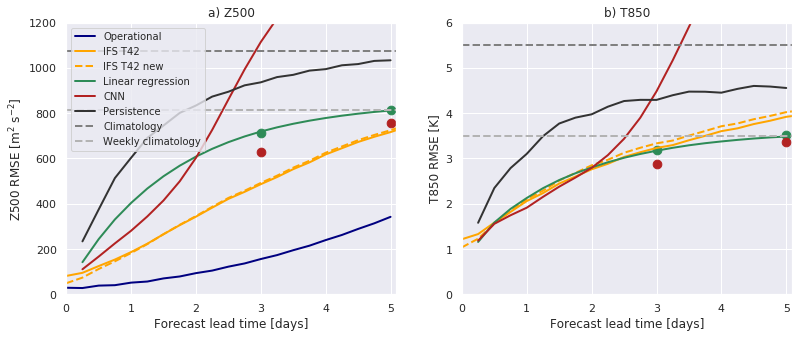

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
create_plot('z', ax=ax1)
create_plot('t', ax=ax2)
ax1.legend(loc=2, ncol=1, fontsize=10)
fig.savefig('../figures/rmse.pdf', bbox_inches='tight')

## Other figures for paper

In [10]:
sns.set_style('dark')

In [29]:
kwargs

NameError: name 'kwargs' is not defined

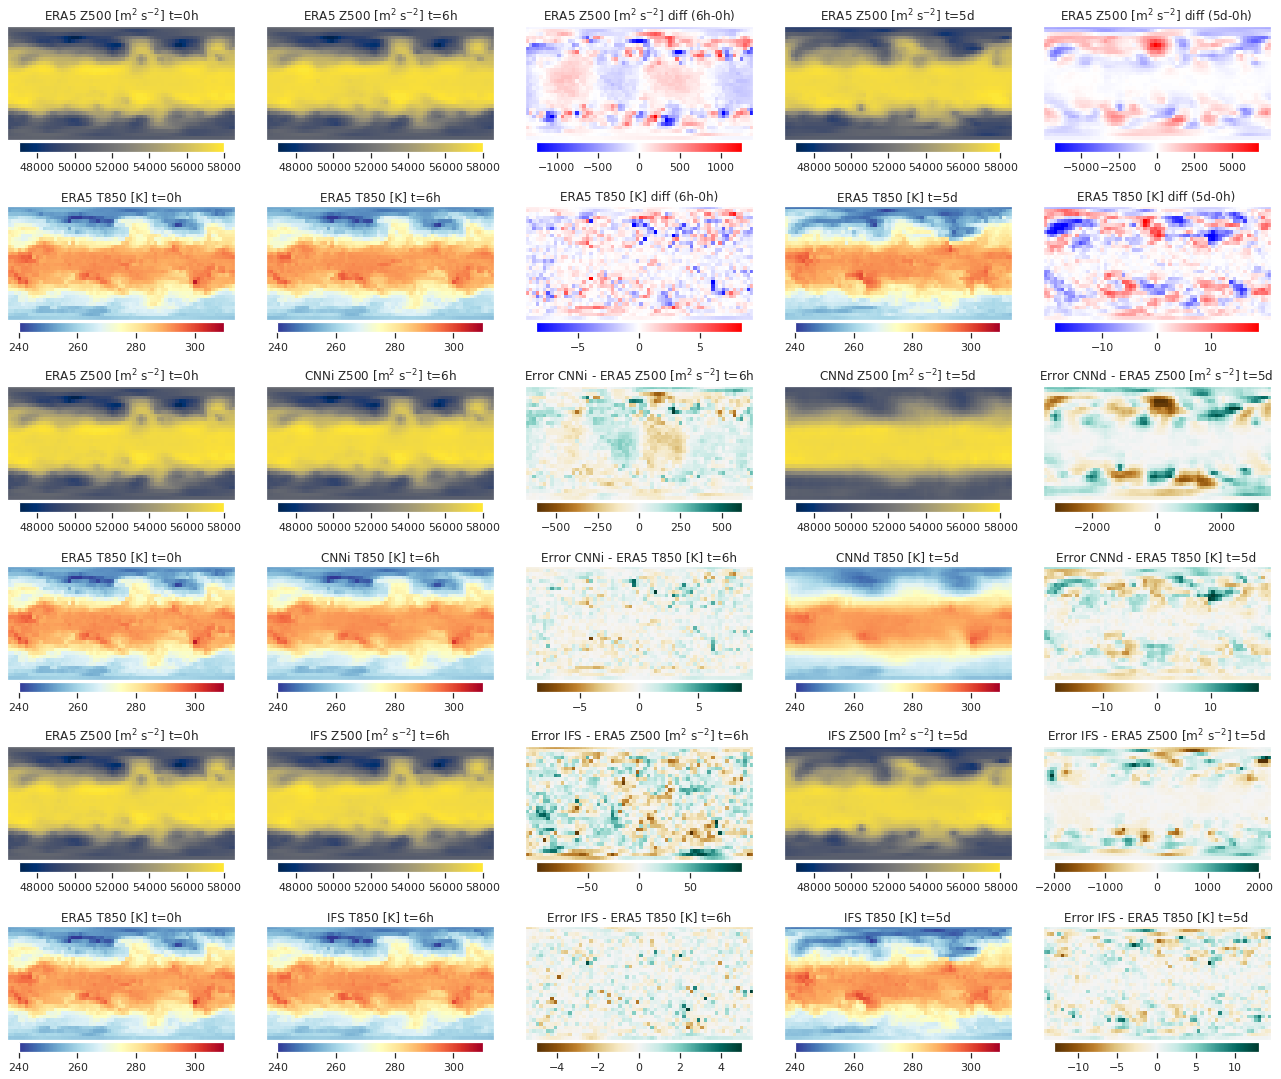

In [49]:
cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
    I = ax.imshow(data, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)

fig, axs = plt.subplots(6, 5, figsize=(18, 15))
# True
for iax, var, cmap, r, t in zip(
    [0, 1], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid_data[var].isel(time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        valid_data[var].isel(time=6)-valid_data[var].isel(time=0), origin='lower', cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], valid_data[var].isel(time=5*24), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        valid_data[var].isel(time=5*24)-valid_data[var].isel(time=0), origin='lower', cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [2, 3], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], cnn_6h_iter[var].isel(time=0).sel(lead_time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNi {t} t=6h')
    imcol(axs[iax,2], 
        cnn_6h_iter[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), origin='lower', cmap=cmap_error,
        title=f'Error CNNi - ERA5 {t} t=6h')
    imcol(axs[iax,3], cnn_5d[var].isel(time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNd {t} t=5d')
    imcol(axs[iax,4], 
        cnn_5d[var].isel(time=0) - valid_data[var].isel(time=5*24), origin='lower', cmap=cmap_error,
        title=f'Error CNNd - ERA5 {t} t=5d')

# IFS
for iax, var, cmap, r, t in zip(
    [4, 5], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], tigge[var].isel(time=0).sel(lead_time=0), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], tigge[var].isel(time=0).sel(lead_time=6), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=6h')
    imcol(axs[iax,2], 
        tigge[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), origin='lower', cmap=cmap_error,
          title=f'Error IFS - ERA5 {t} t=6h')
    imcol(axs[iax,3], tigge[var].isel(time=0).sel(lead_time=5*24), origin='lower', cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'IFS {t} t=5d')
    imcol(axs[iax,4], 
        tigge[var].isel(time=0).sel(lead_time=5*24) - valid_data[var].isel(time=5*24), origin='lower', cmap=cmap_error,
        title=f'Error IFS - ERA5 {t} t=5d')
for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
plt.savefig('../figures/examples.pdf', bbox_inches='tight')

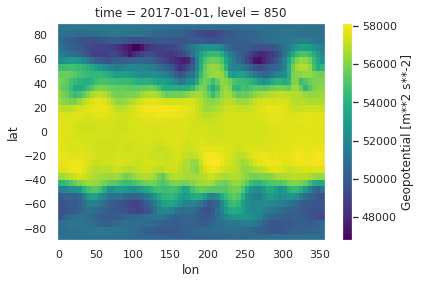

In [29]:
valid_data.z.isel(time=0).plot();

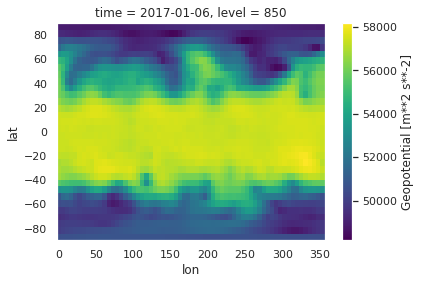

In [21]:
valid_data.z.isel(time=5*24).plot();

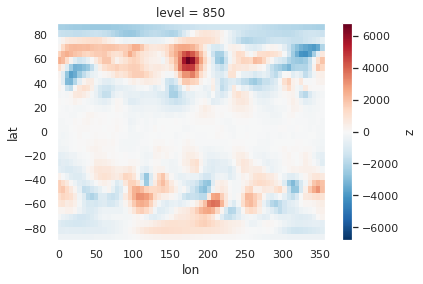

In [22]:
(valid_data.z.isel(time=5*24) - valid_data.z.isel(time=0)).plot();

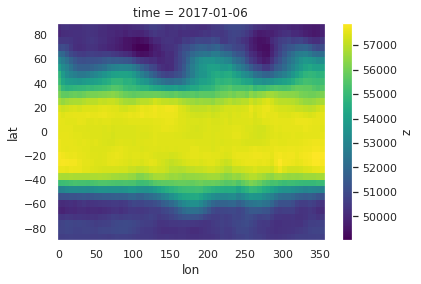

In [23]:
cnn_5d.z.isel(time=0).plot()

In [59]:
def plot_map(data, figsize=(8, 5), cmap='inferno', save_fn=None, dpi=300):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(data, cmap=cmap)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')
    if not save_fn is None:
        fig.savefig(save_fn, dpi=dpi, transparent=True, bbox_inches='tight')

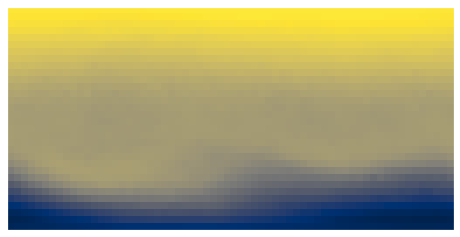

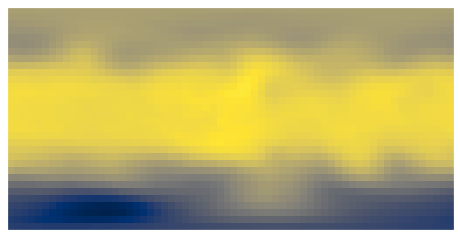

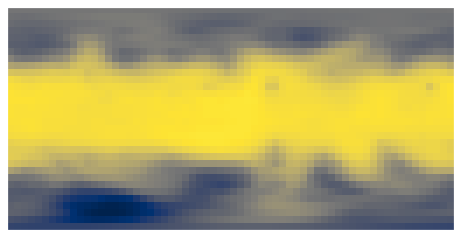

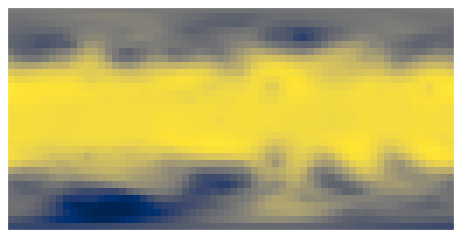

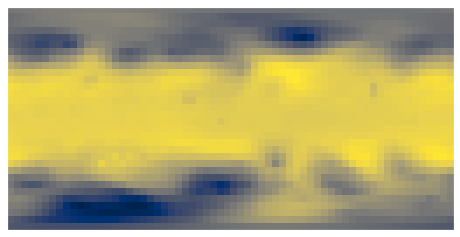

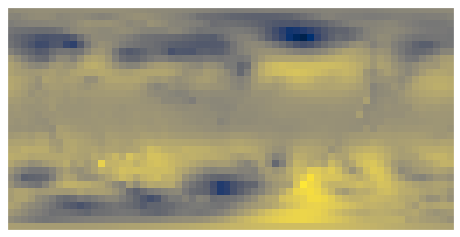

In [60]:
for lev in z.level.values[::2]:
    plot_map(z.isel(time=0).sel(level=lev), cmap='cividis', save_fn=f'../figures/z_{str(lev).zfill(4)}_t0.jpeg')

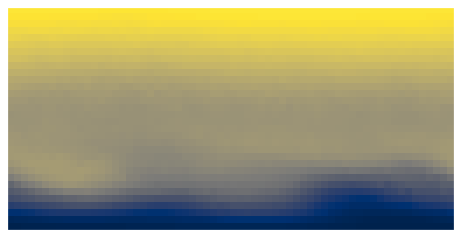

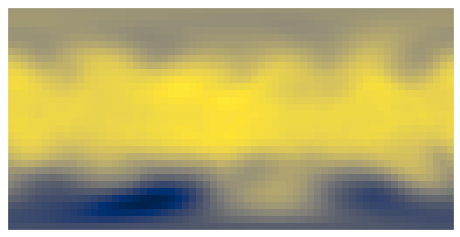

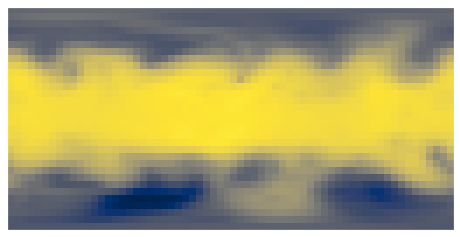

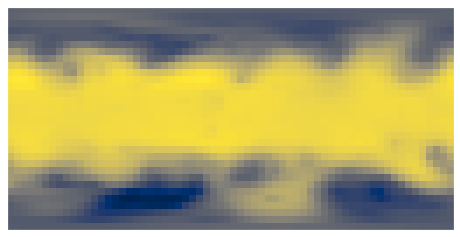

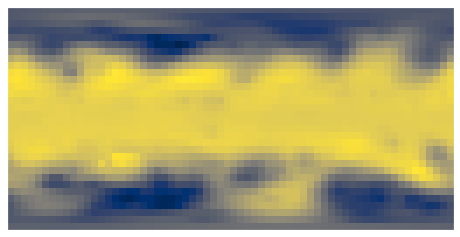

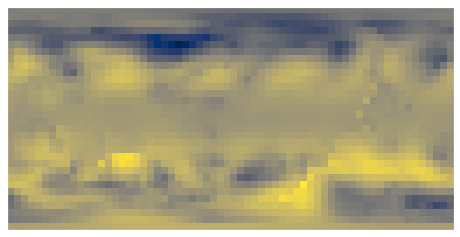

In [61]:
for lev in z.level.values[::2]:
    plot_map(z.isel(time=5*24).sel(level=lev), cmap='cividis', save_fn=f'../figures/z_{str(lev).zfill(4)}_t5.jpeg')

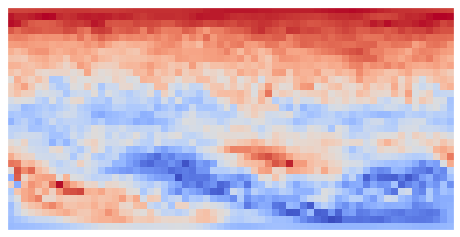

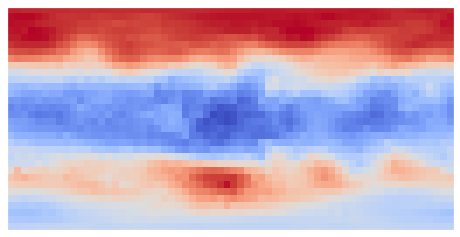

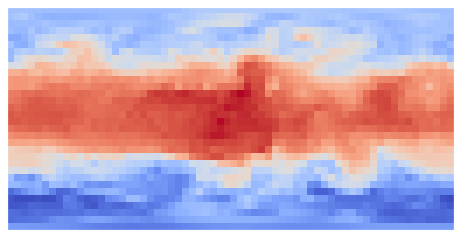

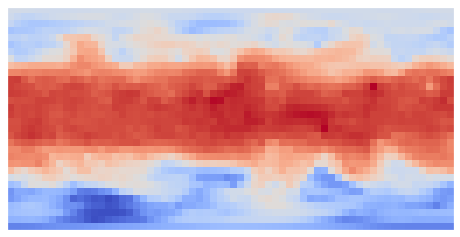

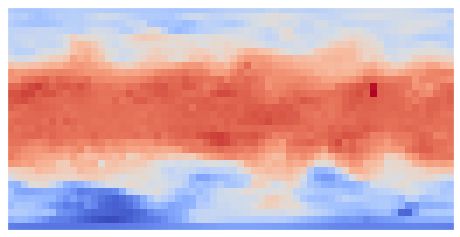

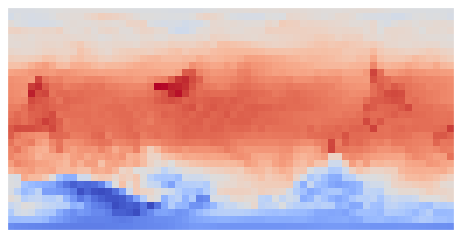

In [62]:
for lev in z.level.values[::2]:
    plot_map(t.isel(time=0).sel(level=lev), cmap='coolwarm', save_fn=f'../figures/t_{str(lev).zfill(4)}_t0.jpeg')

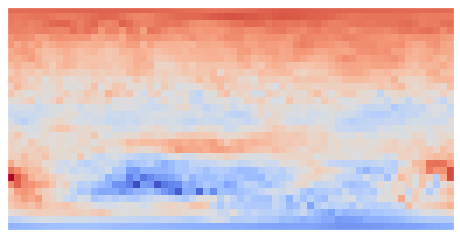

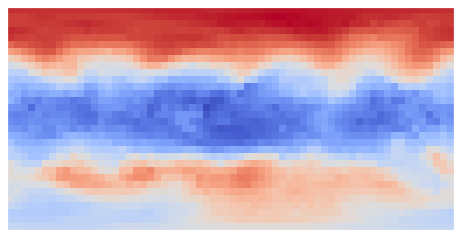

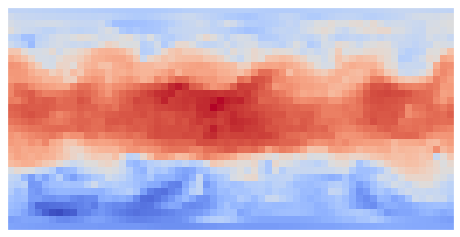

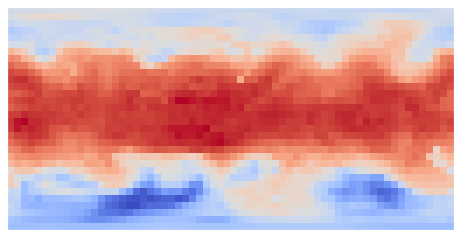

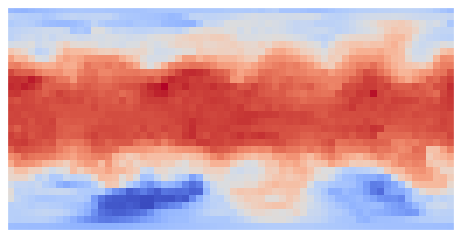

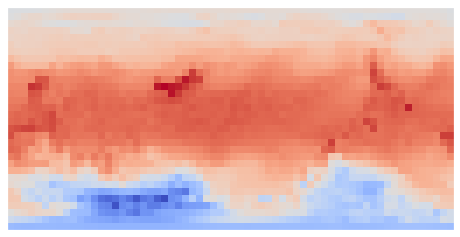

In [63]:
for lev in z.level.values[::2]:
    plot_map(t.isel(time=5*24).sel(level=lev), cmap='coolwarm', save_fn=f'../figures/t_{str(lev).zfill(4)}_t5.jpeg')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


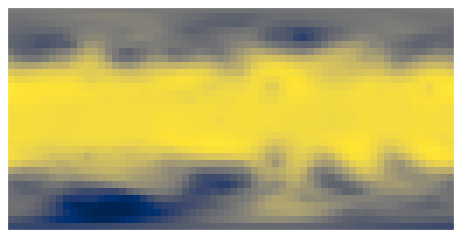

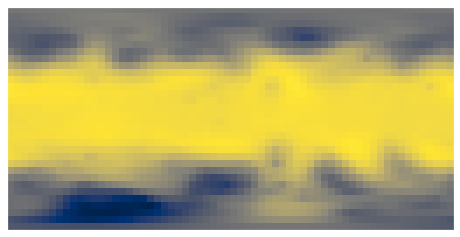

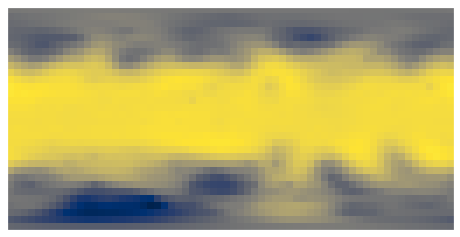

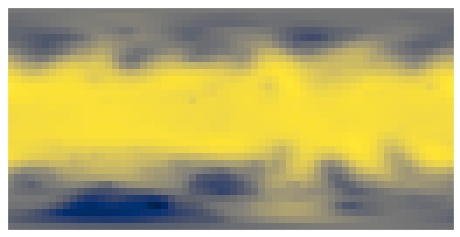

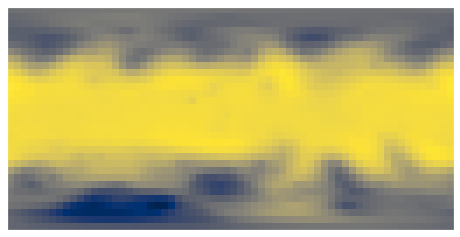

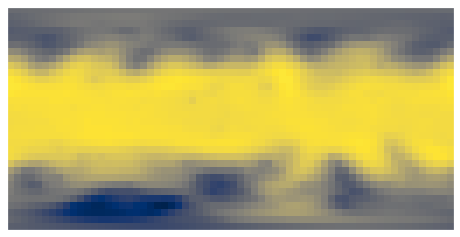

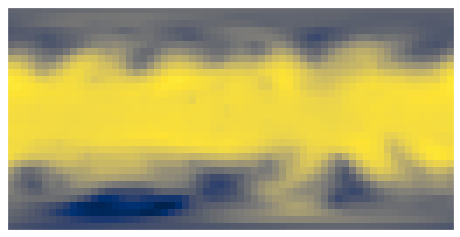

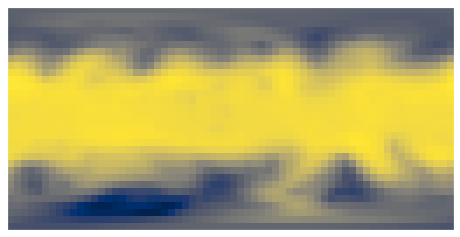

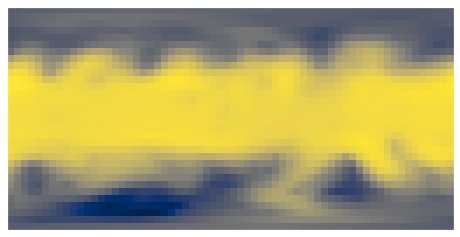

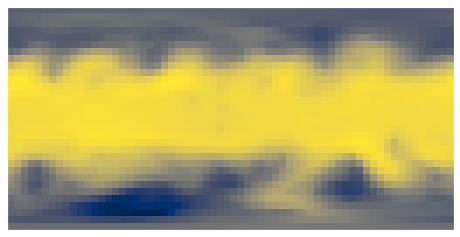

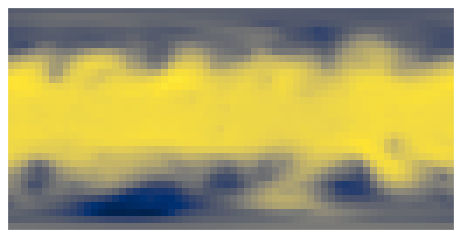

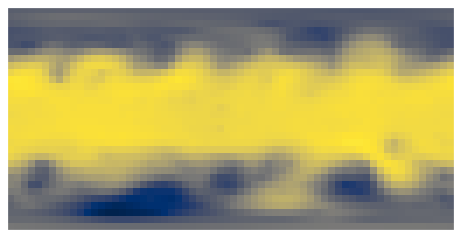

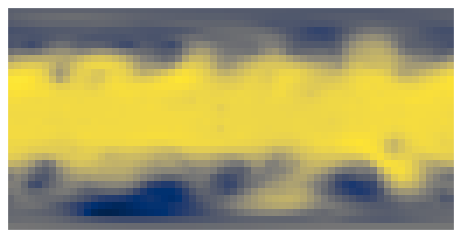

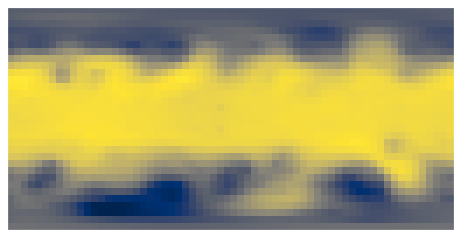

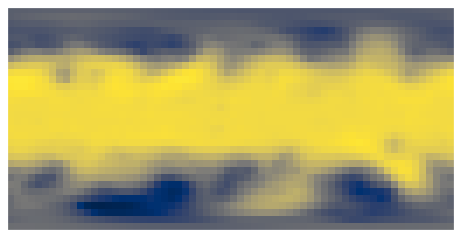

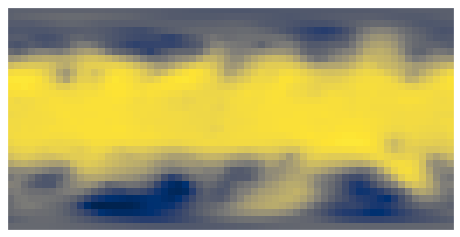

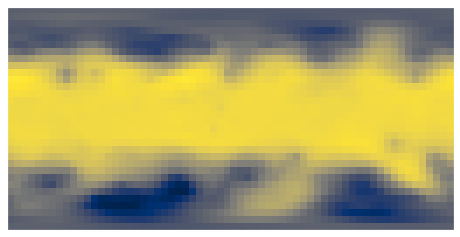

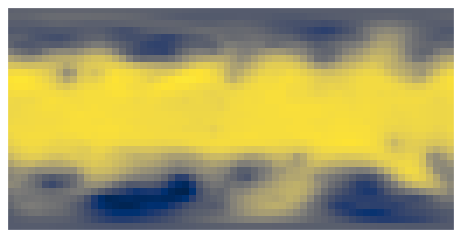

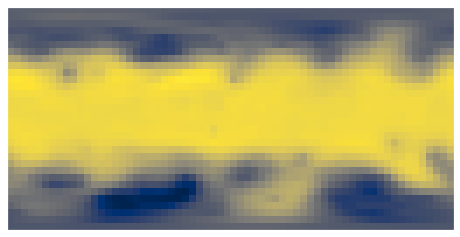

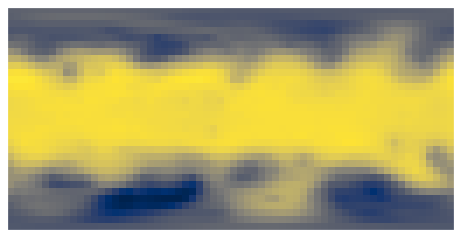

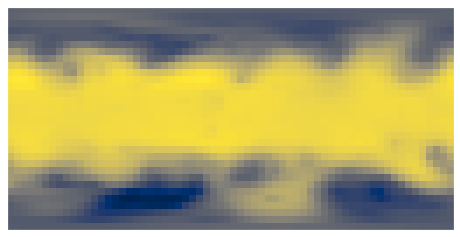

In [64]:
for time in range(0, 126, 6):
    plot_map(z.isel(time=time).sel(level=500), cmap='cividis', save_fn=f'../figures/z500_t{time}h.jpeg')